# Step-by-step example of JDFLOW.
## Kirill Zakharov
2024

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *
from JDFLOW.FourierFlows import FourierFlow
from JDFLOW.FSDE import train
from JDFLOW.evaluate.metrics import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [142]:
len(np.arange(2, 12, 2)) * len(np.arange(700, 1100, 100)) * len(np.arange(5, 130, 40))

80

In [3]:
# data = pd.read_csv('Data/gen.us.txt')['Close'].values
# data2 = pd.read_csv('Data/amzn.us.txt')['Close'].values

In [4]:
# plt.plot(data)
# # plt.plot(data2)

# plt.show()

In [5]:
# data = np.log1p(data)
# data2 = np.log1p(data2)

# scaler = MinMaxScaler((0, 1))

# data = scaler.fit_transform(data.reshape(-1, 1)).T[0]
# data2 = scaler.fit_transform(data2.reshape(-1, 1)).T[0]
# data2 = data2[:len(data)]

In [6]:
# plt.plot(data)
# plt.plot(data2)
# plt.show()

In [7]:
# data_tensor = torch.FloatTensor(np.vstack([data, data2]))
# data0 = data_tensor[0]

In [8]:
# def create_setA(data: np.array) -> torch.Tensor:
#     set_A = torch.zeros(len(data), len(data))
#     k = 1
#     for i in range(len(data)):
#         set_A[i, :k] = torch.FloatTensor(data[:k])
#         k += 1
    
#     return set_A

In [50]:
# set_A = torch.stack(list(map(lambda x: create_setA(x), data)))

In [51]:
# np.linalg.eig(np.matmul(set_A[0], np.transpose(set_A[0])))[0]

In [11]:
# set_A = create_setA(data)

## Data Preparation

In [247]:
n = 2000 #set the series length
dt = 1/n

#choose any of type process or upload your data. The main rule that length of each series must be the same.
# data = dclProcess(n, 10).T
data = np.array([merton_process(s0=1, xiP=3, muj=0, sigmaj=0.2, r=0.04, sigma=0.6, n=n, T=1) for i in range(5)])
# data = np.array([geometric_BM(s0=1, mu=0.1, sigma=0.5, n=n, T=1) for i in range(10)])

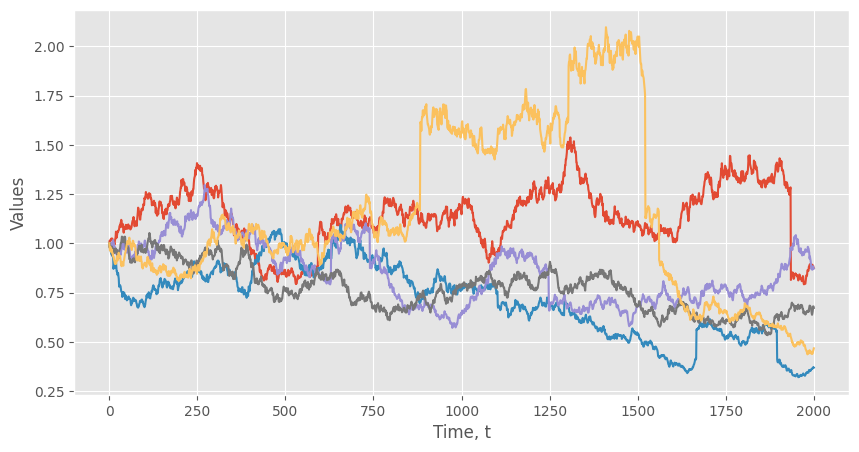

In [248]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T)

plt.xlabel('Time, t')
plt.ylabel('Values')
plt.show()

Save initial data

In [249]:
data_save = copy.deepcopy(torch.FloatTensor(data))

Preprocess the data

In [250]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [251]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

## Identify jump intensity

Choose the $\lambda_j$ to identify the initial jump intensity in the whole data set.

In [252]:
lambda_j = 0.1
idx_jumps = list(map(lambda x: find_jumps(x, lambda_j), data_save))

Black points show the jump positions in the inital data.

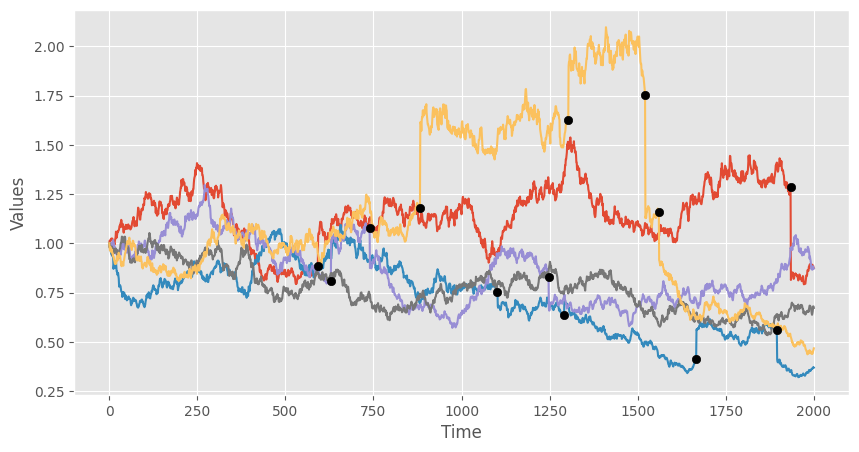

In [253]:
plot_jumps(data_save, idx_jumps)

Initial intensity

In [254]:
init_intensity = estimate_init_intensity_array(data_save, idx_jumps)/dt
init_intensity

array([1.9990005 , 3.998001  , 2.99850075, 0.        , 3.998001  ])

Initital parameters

In [255]:
jump_part, diff_part = separate_dynamics(data_save, idx_jumps)
init_params = estimate_init_params(data_save, jump_part, diff_part, dt)

Maximize likelihood

In [256]:
opt_params = optimize_params(data_save, init_params, init_intensity, dt)

In [257]:
xiP0 = opt_params[-1]
xiP0

2.598700649675162

## Signature Examples

In [258]:
signature_traj = compute_path_signature_torch(data_save, level_threshold=3)
signature = signature_set(signature_traj)[1:]

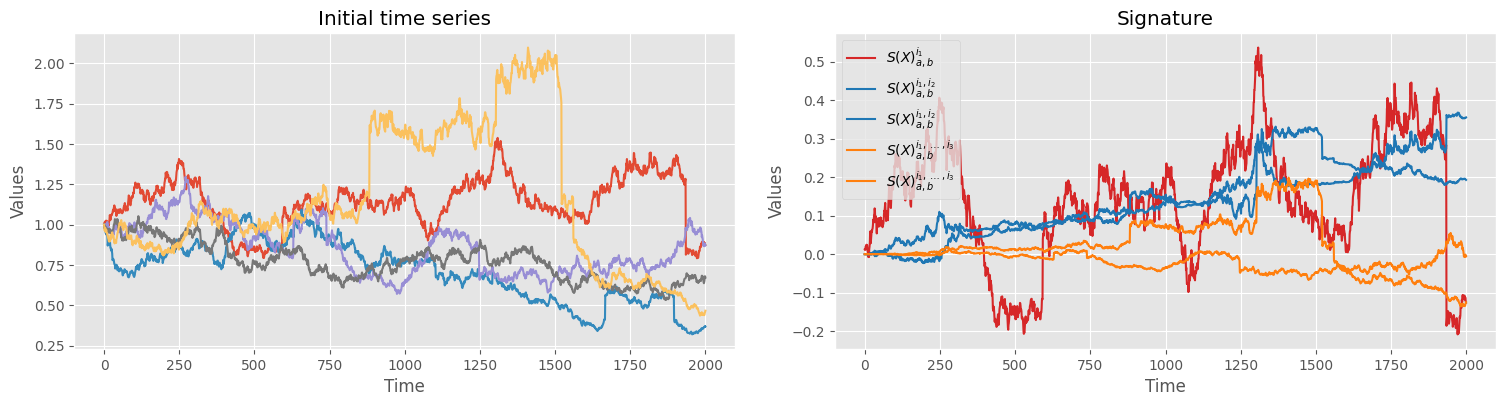

In [259]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_save.T)
axs[0].set_title('Initial time series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(signature_traj[1][0], color='tab:red', label='$S(X)_{a,b}^{i_1}$')
axs[1].plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[2][4], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[3][2], color='tab:orange', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
axs[1].plot(signature_traj[3][4], color='tab:orange', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')
axs[1].legend(fontsize=10, loc=2)
axs[1].set_title('Signature')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Signature_ex4.pdf', dpi=300)
plt.show()

## Train model

In [297]:
class DiffMap(nn.Module):
    def __init__(self, time_steps, h_dim, M, dt, permute):
        super(DiffMap, self).__init__()
    
        self.h_dim = h_dim
        self.laten_dim = M
        self.time_steps = time_steps
        self.dt = dt

        hidden = 2**7
        self.v_dim = M
        self.d = h_dim // 2
        self.r = M // 2
        self.permute = permute
        
        self.in_size = self.d
        self.out_size = self.h_dim - self.d

    
        if self.permute:
            self.in_size, self.out_size = self.out_size, self.in_size

        
        self.fc_mu = nn.Sequential(
            # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_sig = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.nu = nn.Sequential(
            nn.Linear(M, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, M)
        )
   
        self.p = nn.Sequential(
            # nn.LSTM(self.time_steps, self.time_steps, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.time_steps, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.in_size)
        )
        self.tanh = nn.Tanh()
        
        self.f = nn.Sequential(nn.Linear(self.in_size, hidden),
                               nn.Sigmoid(),
                               nn.Linear(hidden, self.out_size))
        
        self.base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))

    def forward(self, x, vt):
        x1, x2 = x[:, :self.d], x[:, self.d:]
    
        if self.permute:
            x2, x1 = x1, x2
        
        p_hat = self.tanh(self.p(vt.T))
        z1 = x1 + p_hat
        sig = self.fc_sig(z1)
        z2 = self.fc_mu(z1) * self.f(self.nu(z1.T).T) + x2 * torch.exp(sig)
        
        if self.permute:
            z2, z1 = z1, z2 
 
        z = torch.cat([z1, z2], axis=1)
        
        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob
    
        

    def inverse(self, z, vt):
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        if self.permute:
            z2, z1 = z1, z2
            
        x2 = (z2 - self.fc_mu(z1) * self.f(self.nu(z1.T).T)) * torch.exp(-self.fc_sig(z1))
        
        p_hat = self.tanh(self.p(vt.T))
        x1 = z1 - p_hat
      
        if self.permute:
            x2, x1 = x1, x2
        
        x = torch.cat([x1, x2], axis=1)

        return x



class Flow(nn.Module):
    def __init__(self, n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0):
        super(Flow, self).__init__()
        
        self.h_dim = h_dim
        self.permute = [True if i % 2 else False for i in range(n_flows)]

        self.bijections = nn.ModuleList(
            [DiffMap(time_steps, h_dim, M, dt, self.permute[i]) for i in range(n_flows)]
        )
        
        self.xiP = xiP0
        
        self.time_steps = time_steps
        self.dt = dt
        self.v_dim = M
        self.psi = Operator_F(self.time_steps, self.h_dim)
        self.zeta = Operator_F(self.h_dim, self.h_dim)
        
        self.drift = Drift(self.v_dim)
        self.diffusion = Diffusion(self.v_dim, 1)
        self.jump = Jump(self.v_dim)
        self.phi = Phi(self.v_dim, M, M)
        self.sigmoid_sig = nn.Sigmoid()

    def forward(self, x):
        log_jacobs = []
        
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
        self.vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(self.vt.T))
        x = self.non_linearity * x + self.zeta(self.non_linearity)
        

        for bijection in self.bijections:
            x, log_pz, lj = bijection(x, self.vt)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):
        
        # wt = torch.randn((1, self.v_dim))
        # v0 = self.phi(wt, z[:, 0].view(1, z.size(0)))
        # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)

        for bijection in reversed(self.bijections):
            z = bijection.inverse(z, self.vt)
            
        self.non_linearity = torch.exp(-self.psi(self.vt.T))
        z = (z - self.zeta(self.non_linearity)) / self.non_linearity


        return z
    
    def fit(self, X, epochs=1000, learning_rate=1e-3):
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[400], gamma=0.3)
       
        losses = []
        mse = nn.MSELoss()
        epochs = tqdm(range(epochs))

        for _ in epochs:
            _, log_pz, log_jacob = self.forward(X)
            
            # p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
            # z = p_Z.rsample(sample_shape=(X.size(0),))
            # synth_x = self.inverse(z)
            
            # signature = (stack_signatures(compute_path_signature_torch(synth_x, level_threshold=2)[1:]))
            # signature_true = (stack_signatures(compute_path_signature_torch(X, level_threshold=2)[1:]))
            
            loss_likelihood = (-log_pz - log_jacob).mean() 
          
            # loss_sig = mse(signature, signature_true)
            # loss_init_values = torch.mean((X[:, 0] - synth_x[:, 0])**2)
            loss_sig = loss_likelihood
            loss_init_values = loss_likelihood
            
            total_norm = 0.0
            for p in self.parameters():
                param_norm = p.norm(2)
                total_norm += param_norm.item() ** 2
                total_norm = total_norm ** (1. / 2)
        
            loss = loss_likelihood + total_norm 
            # + 0.01 * loss_sig + loss_init_values + total_norm
            

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')
            losses.append([loss_likelihood.item(), loss_init_values.item(), loss_sig.item()])
            
        return np.array(losses)
            
    
    def sample(self, n_samples):
        samples_array = []
            
        if n_samples % self.v_dim == 0:
            for i in range(n_samples // self.v_dim):
                p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
                z = p_Z.rsample(sample_shape=(self.v_dim,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
                
            samples_array = np.vstack(samples_array)
                
        else:
            for i in range(n_samples // self.v_dim + 1):
                p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
                z = p_Z.rsample(sample_shape=(self.v_dim,))

                X_sample = self.inverse(z).detach().numpy()
                samples_array.append(X_sample)
              
            samples_array = np.vstack(samples_array)[:n_samples]

        return samples_array

In [298]:
# data_tensor = data_tensor.view(1, -1) #if use only one series

In [299]:
data_tensor.size()

torch.Size([5, 2001])

In [300]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
time_steps = 100
dt = torch.FloatTensor([1/time_steps])
# n = data_tensor.size(0)
sig_dim = n + n**2 

In [301]:
# nsde_flow = Flow(128, 10, h_dim, h_dim)
n_flows = 10

nsde_flow = Flow(n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=1000)

Loss: -9096.9043: 100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s]


In [302]:
nsde_flow.eval()

Flow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): Linear(in_features=1000, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=1001, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(1000, 1000, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=1000, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=1001, bias=True)
      )
      (nu): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=5, bias=True)
      )
      (p): S

In [303]:
samples = nsde_flow.sample(5)
# samples = samples[(~(np.max(samples, axis=1) > 1.5*np.max(data))) & (~(np.min(samples, axis=1) < 1.5*np.min(data)))]

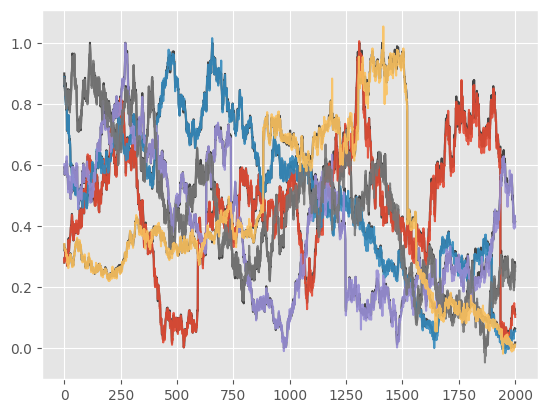

In [304]:
plt.plot(data_tensor.T, color='black', alpha=0.7, label='Real')
plt.plot(samples[:, :].T, alpha=0.9, label='Synth')

# plt.legend()
plt.show()

In [305]:
def inverse_preprocessing(samples):
    synth_data = []

    if samples.shape[0] % M == 0:
        for i in range(samples.shape[0] // M):
            synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
    else:
        for i in range(samples.shape[0] // M):
            synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
        last = samples.shape[0] % M
        synth_data.append(scaler.inverse_transform(np.vstack([samples[-last:], np.ones((M - last, samples.shape[1]))]).T).T[:last])
        
    synth_data = np.vstack(synth_data)
    
    return synth_data

In [306]:
synth_data = inverse_preprocessing(samples)
real_data = scaler.inverse_transform(data.T).T

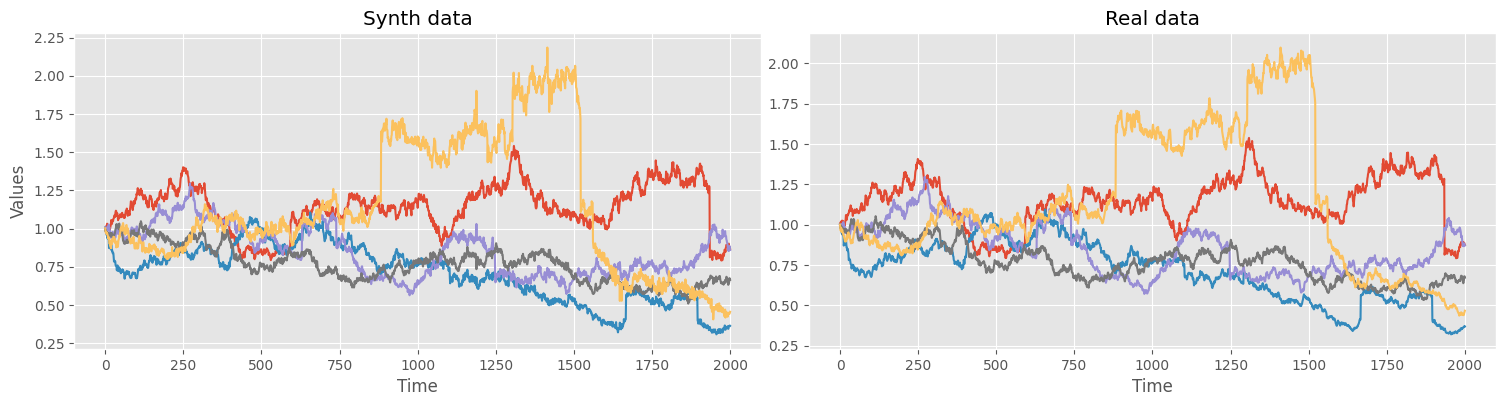

In [307]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data[:].T)
axs[0].set_title('Synth data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(real_data[:].T)
axs[1].set_title('Real data')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_many_synth2.pdf', dpi=300)
plt.show()

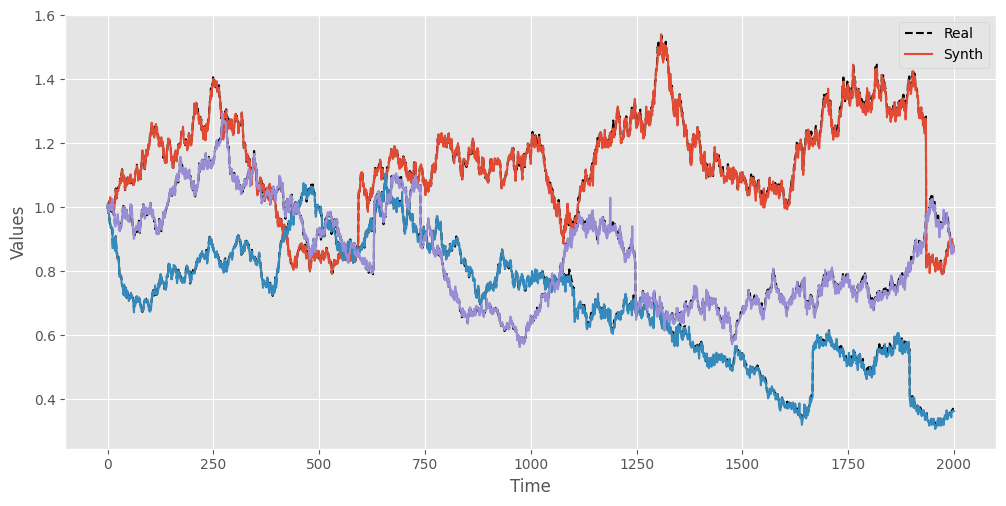

In [308]:
def plotCollection(ax, ys, *args, **kwargs):

  ax.plot(ys, *args, **kwargs)

  if "label" in kwargs.keys():

    #remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
      if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

    plt.legend(newHandles, newLabels)

_, ax = plt.subplots(figsize=(10, 5), dpi=100)
plotCollection(ax, real_data[:3].T, linestyle='--', color='black', label='Real')
plotCollection(ax, synth_data[:3].T, label='Synth')

plt.ylabel('Values')
plt.xlabel('Time')
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_3_plots.pdf', dpi=300)
plt.show()

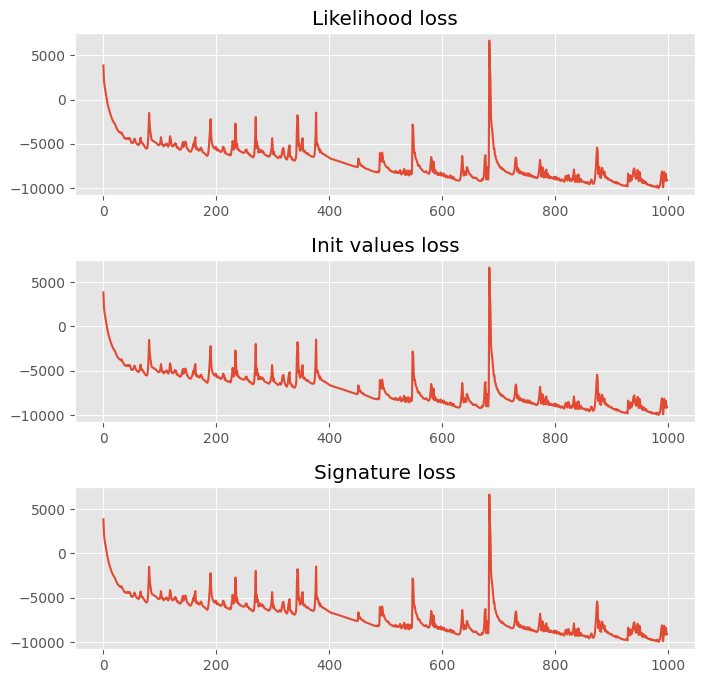

In [310]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(losses.T[0])
axs[0].set_title('Likelihood loss')

axs[1].plot(losses.T[1])
axs[1].set_title('Init values loss')

axs[2].plot(losses.T[2])
axs[2].set_title('Signature loss')

plt.subplots_adjust(hspace=0.4)
plt.show()

## Fourier Flows

In [311]:
data_tensor = data_tensor[:, :(len(data_tensor[0]) // 4 * 4 + 1 if len(data_tensor[0]) % 4 > 0 else len(data_tensor[0]) - 3)]

In [314]:
fourier_flow = FourierFlow(2**7, len(data_tensor[0]), 10, FFT=True, flip=True, normalize=False)

fourier_flow.fit(data_tensor, epochs=1000)

Loss: -20417.890625: 100%|██████████| 1000/1000 [16:11<00:00,  1.03it/s]   


In [315]:
rnvp_flow = FourierFlow(2**7, len(data_tensor[0]), 10, FFT=False, flip=True, normalize=False)

rnvp_flow.fit(data_tensor, epochs=100)

Loss: -3671.532470703125: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [316]:
samples_ff = fourier_flow.sample(5)
samples_rnvp = fourier_flow.sample(5)

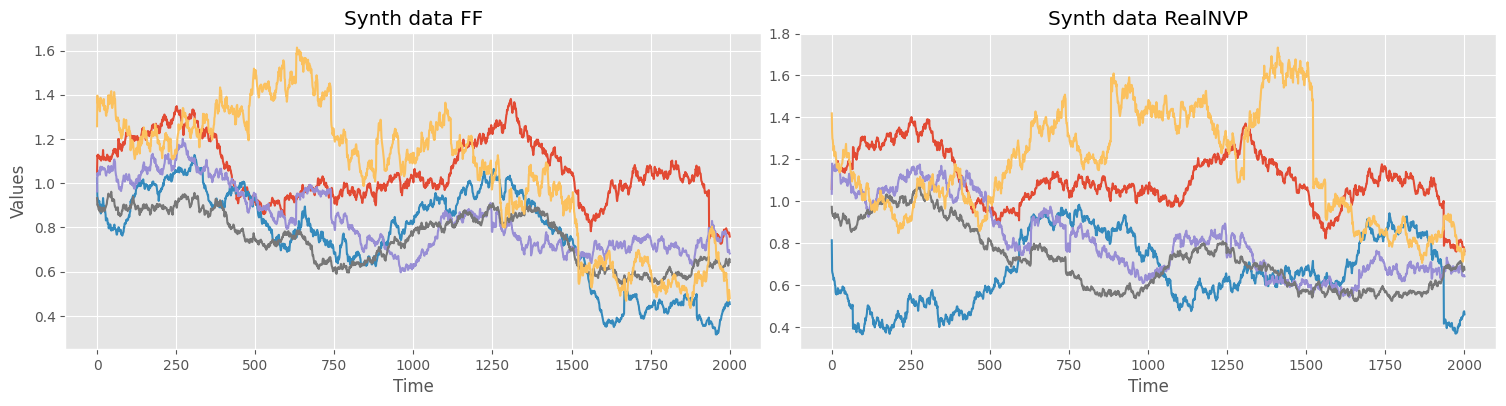

In [317]:
synth_ff = inverse_preprocessing(samples_ff)
synth_rnvp = inverse_preprocessing(samples_rnvp)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_ff.T)
axs[0].set_title('Synth data FF')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(synth_rnvp.T)
axs[1].set_title('Synth data RealNVP')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FF.pdf', dpi=300)
plt.show()

In [113]:
samples_fsde = []
for i in data_tensor:
    samples_fsde.append(train(i.view(-1, 1), method='fSDE', epochs=10))
    
samples_fsde = np.array(samples_fsde)[:,0]

In [114]:
synth_fsde = inverse_preprocessing(samples_fsde)

In [115]:
synth_fsde = synth_fsde[np.random.randint(0, len(synth_fsde), M)]

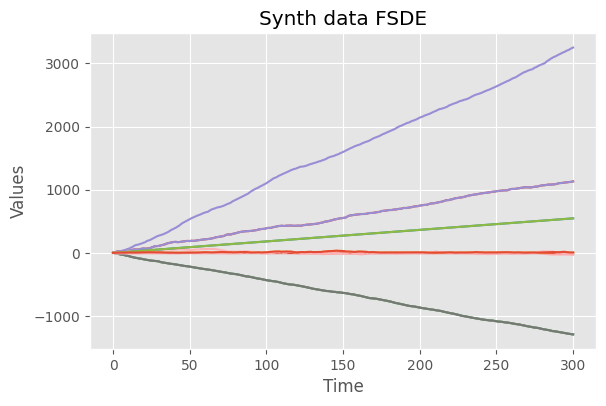

In [116]:
plt.subplots(figsize=(6, 4), dpi=100)

plt.plot(synth_fsde.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Synth data FSDE')

plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FSDE.pdf', dpi=300)
plt.show()

## Evaluate

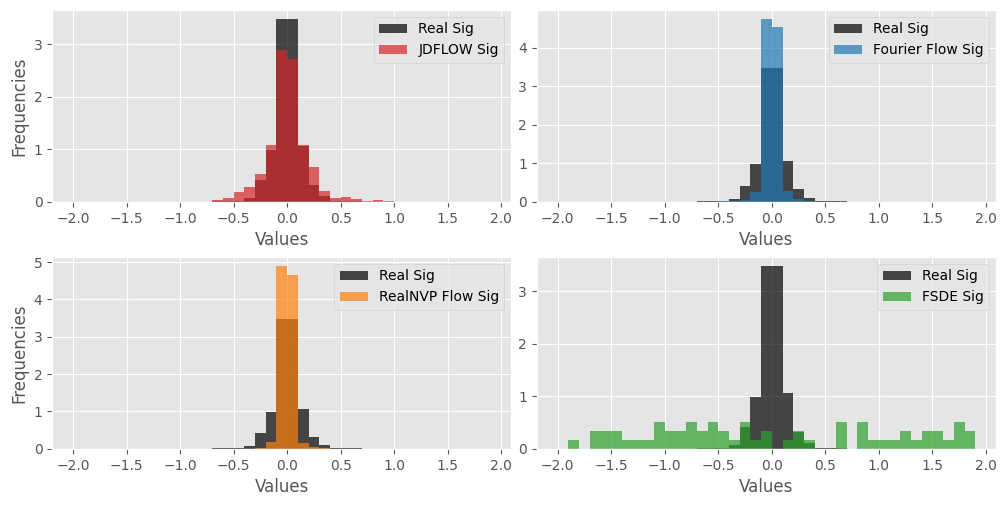

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
signature = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature_real = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_ff), level_threshold=3)
signature_ff = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_rnvp), level_threshold=3)
signature_rnvp = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_fsde), level_threshold=3)
signature_fsde = signature_set(signature_traj)[1:]



axs[0, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7, density=True)
axs[0, 0].hist(signature, bins=np.arange(-2, 2, 0.1), label='JDFLOW Sig', color='tab:red', alpha=0.7, density=True)
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Frequencies')
axs[0, 0].legend()


axs[0, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7, density=True)
axs[0, 1].hist(signature_ff, bins=np.arange(-2, 2, 0.1), label='Fourier Flow Sig', color='tab:blue', alpha=0.7, density=True)
axs[0, 1].set_xlabel('Values')
# axs[0, 1].set_ylabel('Frequencies')
axs[0, 1].legend()


axs[1, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7, density=True)
axs[1, 0].hist(signature_rnvp, bins=np.arange(-2, 2, 0.1), label='RealNVP Flow Sig', color='tab:orange', alpha=0.7, density=True)
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Frequencies')
axs[1, 0].legend()


axs[1, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.7, density=True)
axs[1, 1].hist(signature_fsde, bins=np.arange(-2, 2, 0.1), label='FSDE Sig', color='tab:green', alpha=0.7, density=True)
axs[1, 1].set_xlabel('Values')
# axs[0, 0].set_ylabel('Frequencies')
axs[1, 1].legend()

plt.subplots_adjust(wspace=0.3)
plt.tight_layout(pad=0.5)
# plt.savefig(f'Signature_DCL.pdf', dpi=300) #save figure
plt.show()

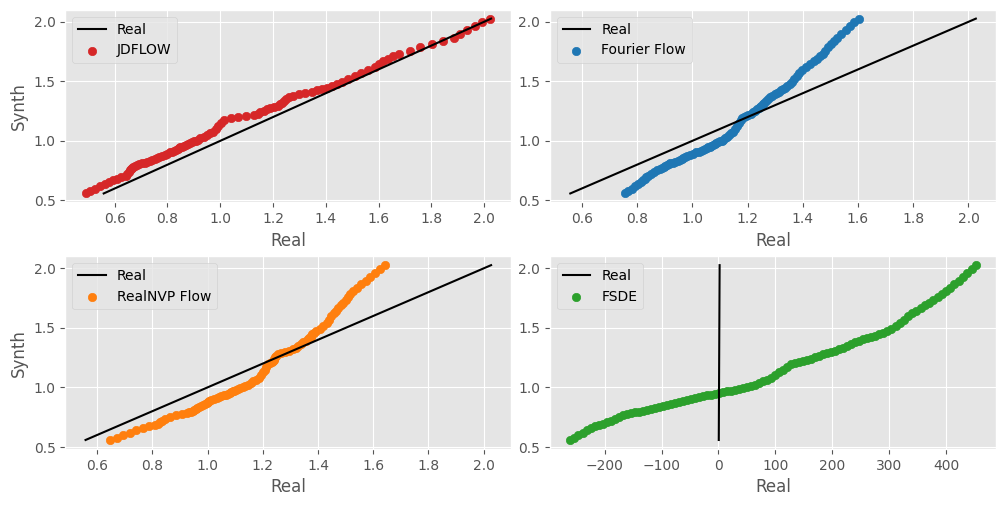

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

# plt.plot(np.arange(2), label='Real', color='black')

axs[0, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 0].scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:red', label='JDFLOW')
axs[0, 0].set_xlabel('Real')
axs[0, 0].set_ylabel('Synth')
axs[0, 0].legend()


axs[0, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 1].scatter(extr_quant_computation(synth_ff), extr_quant_computation(real_data), color='tab:blue', label='Fourier Flow')
axs[0, 1].set_xlabel('Real')
# axs[0, 1].set_ylabel('Synth')
axs[0, 1].legend()


axs[1, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 0].scatter(extr_quant_computation(synth_rnvp), extr_quant_computation(real_data), color='tab:orange', label='RealNVP Flow')
axs[1, 0].set_xlabel('Real')
axs[1, 0].set_ylabel('Synth')
axs[1, 0].legend()


axs[1, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 1].scatter(extr_quant_computation(synth_fsde), extr_quant_computation(real_data), color='tab:green', label='FSDE')
axs[1, 1].set_xlabel('Real')
# axs[1, 1].set_ylabel('Synth')
axs[1, 1].legend()


plt.tight_layout(pad=0.5)
# plt.savefig(f'Extrema_DCL.pdf', dpi=300) #save figure
plt.show()

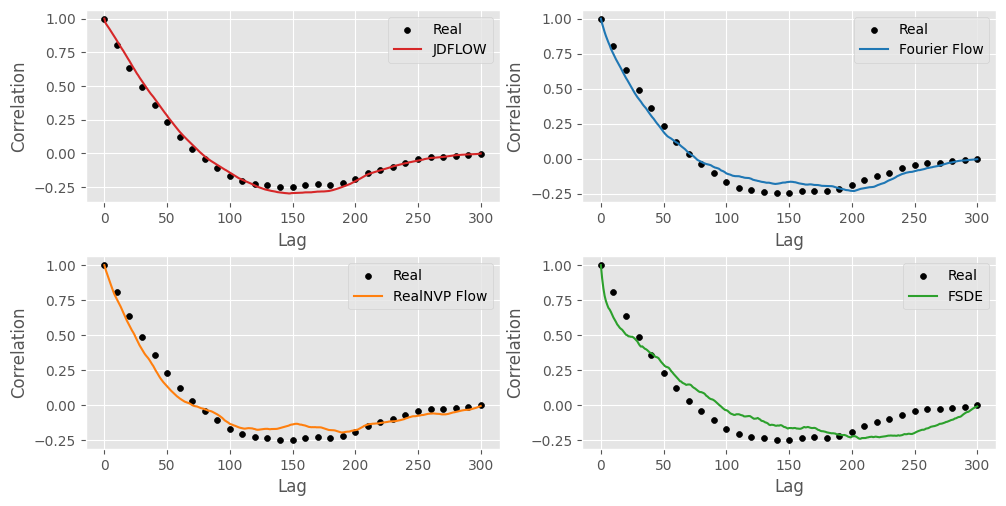

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 0].plot(autocorr_vec(synth_data), label = 'JDFLOW', color='tab:red')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('Correlation')
axs[0, 0].legend()


axs[0, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 1].plot(autocorr_vec(synth_ff), label = 'Fourier Flow', color='tab:blue')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('Correlation')
axs[0, 1].legend()

axs[1, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 0].plot(autocorr_vec(synth_rnvp), label = 'RealNVP Flow', color='tab:orange')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('Correlation')
axs[1, 0].legend()

axs[1, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 1].plot(autocorr_vec(synth_fsde), label = 'FSDE', color='tab:green')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('Correlation')
axs[1, 1].legend()


plt.xticks()
plt.yticks()
plt.tight_layout(pad=0.5)
# plt.savefig(f'Autocorr_DCL.pdf', dpi=300) #save figure
plt.show()

In [120]:
pd.DataFrame(np.array([[w_dist_calc(real_data, real_data), w_dist_calc(real_data, synth_data),
                        w_dist_calc(real_data, synth_ff), w_dist_calc(real_data, synth_rnvp), w_dist_calc(real_data, synth_fsde)],
                       
                       [js_calc(np.abs(real_data), np.abs(real_data)), js_calc(np.abs(real_data), np.abs(synth_data)),
                        js_calc(np.abs(real_data), np.abs(synth_ff)), js_calc(np.abs(real_data), np.abs(synth_rnvp)), js_calc(np.abs(real_data), np.abs(synth_fsde))]
                       
                       ]).T, index=['Real', 'JDFLOW', 'FF', 'RealNVP', 'FSDE'], columns=['W_1', 'JS'])

,W_1,JS
Real,0.000000,0.000000
JDFLOW,0.020271,0.021713
FF,0.244392,0.143075
RealNVP,0.245382,0.148983
FSDE,432.253097,0.235323


In [387]:
# drift = Drift(h_dim)
# diffusion = Diffusion(h_dim, 1)
# jump = Jump(h_dim)

# optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
# optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
# optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
# scheduler_drift = optim.lr_scheduler.MultiStepLR(optim_drift, milestones=[20], gamma=0.3)
# scheduler_diffusion = optim.lr_scheduler.MultiStepLR(optim_diffusion, milestones=[20], gamma=0.3)
# scheduler_jump = optim.lr_scheduler.MultiStepLR(optim_jump, milestones=[20], gamma=0.3)

# epochs_j = tqdm(range(40))
# loss_array_j = []
# mse_j = nn.MSELoss()

# base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
# z = u[0].view(1, -1)
# xiP = 30

# for _ in epochs_j:  
#     # z = base_dist.rsample((10, ))
    
#     # xiP = xi()
    
#     x = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, xiP)
#     # inv_sol = sdeint_jump_inverse(drift, diffusion, jump, dt, x.detach(), time_steps, h_dim).detach()
#     sol = x
    
#     loss_v = mse_j(sol, u) + torch.mean((sol[0] - u[0])**2)
    
#     # for dp in drift.parameters():
#     #     dp.data.clamp_(-0.05, 0.05)
        
#     # for dp in diffusion.parameters():
#     #     dp.data.clamp_(-0.05, 0.05)
        
#     # for dp in jump.parameters():
#     #     dp.data.clamp_(-0.05, 0.05)
        
    
#     optim_drift.zero_grad()
#     optim_diffusion.zero_grad()
#     optim_jump.zero_grad()
#     optim_xi.zero_grad()
    
#     loss_v.backward()
    
#     optim_drift.step()
#     optim_diffusion.step()
#     optim_jump.step()
#     optim_xi.step()
    
#     scheduler_drift.step()
#     scheduler_diffusion.step()
#     scheduler_jump.step()
    
#     epochs_j.set_description(f'Loss: {loss_v.item()}')
#     loss_array_j.append(loss_v.item())


In [386]:
# sol = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, 30)

# plt.plot(u, alpha=0.7, color='black')
# plt.plot(sol.detach().numpy())

# plt.show()